# Diabetes Prediction MLOps Pipeline




## 1. MLflow Setup

In [11]:
import mlflow
from mlflow.models.signature import infer_signature


In [13]:
MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# mlflow.sklearn.autolog()

## 2. Import Libraries

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib

## 3. Initialize DVC and Load Dataset

Following the workflow from our Architecture Plan:
1. Initialize DVC for data versioning
2. Track the raw data state

In [17]:
%cd /home/hn/diabete_prediction

# Load dataset
datapath = "./data/raw_data/diabetes.csv"
df = pd.read_csv(datapath)
df.head(10)

/home/hn/diabete_prediction


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [20]:
# Initialize DVC and capture raw data state
! dvc init
! dvc add data


6920.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


6926.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/hn/diabete_prediction/.dvc/cache/files/md5'| |0/? 
                                                                                
!
  0%|          |Adding data to cache                  0/1 [00:00<?,     ?file/s]
                                                                                
!
Checking out /home/hn/diabete_prediction/data         |0.00 [00:00,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 47.95file/s]

To track the changes with git, run:

	git add .gitignore data.dvc

To enable auto staging, run:

	dvc config core.autostage true
⠋ Checking graph
Adding...                                                                       
!
                                                     

In [22]:
! git add data.dvc .gitignore
! git commit -m "Raw diabetes data"

7139.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7144.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7144.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[main 8a8ba63] Raw diabetes data
 5 files changed, 14 insertions(+), 1 deletion(-)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 data.dvc


## 4. EDA



This dataset is comprised of 8 input variables that describe medical details of patients and one output variable to indicate whether the patient will have an onset of diabetes within 5 years

source: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

We might infer the target column is "Outcome" and the rest are the feature columns.

Pregnancies: Number of pregnancies

Glucose: 2-hour plasma glucose concentration during an oral glucose tolerance test

Blood Pressure: Blood Pressure (Diastolic)(mm Hg)

SkinThickness : Thickness of skin

Insulin: 2-Hour Serum Insulin (mu U/ml)

DiabetesPedigreeFunction: Function (2-hour plasma glucose concentration during an oral glucose tolerance test)

BMI: Body Mass Index (weight in kg/(height in meters)^2)

Age: Persons age(in years)

Outcome: Having diabetes status (1: diabetes, 0: no diabetes )

In [23]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [24]:
df.info()
print("\nMissing values check:", df.isnull().values.any())
print("Duplicate records:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing values check: False
Duplicate records: 0


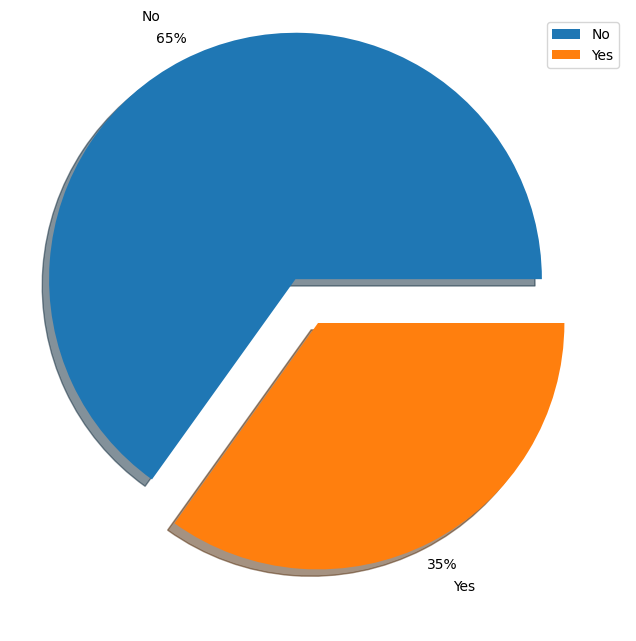

In [36]:
list_pie = list(df['Outcome'].value_counts())
temp_list = []

labels = ["No","Yes"]
for pie in list_pie:
  temp_list.append((pie/df.shape[0])*100)
myexplode = [0.2, 0]

sizes = temp_list

fig = plt.figure(figsize =(10, 8))
plt.pie(sizes, labels = labels,explode = myexplode, shadow = True,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.legend()
plt.show()

<Figure size 2000x1500 with 0 Axes>

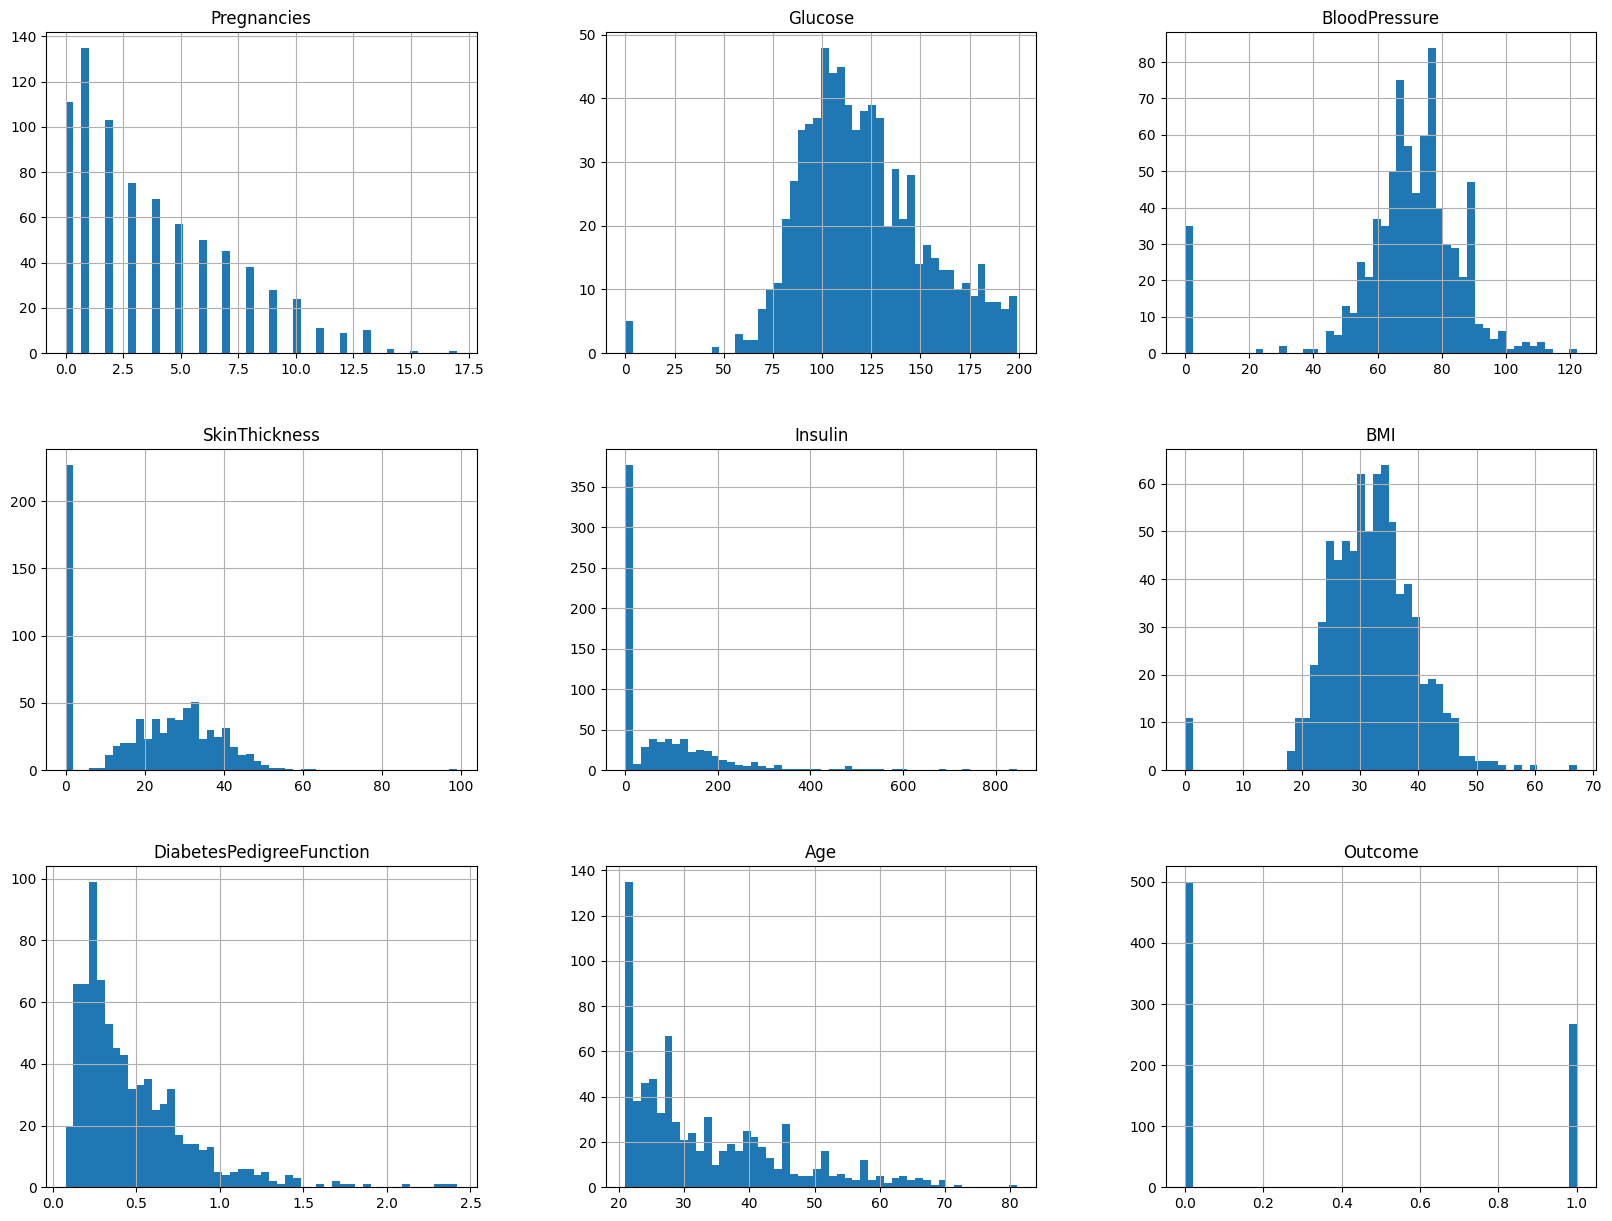

In [34]:
plt.figure(figsize=(20, 15))
df.hist(bins=50, figsize=(20, 15))
plt.show()

+ The SkinThickness, Insulin and Age have higher first bins
than nearby bins, indicating that the possibility of values being clipped at those values.

+ we observed a high value of 0 in values such as Glucose, BloodPressure, SkinThickness, Insulin, and BMI in our dataset. These values cannot be 0!!! So we need replace them with other values.

+ We also have some right-tail skewed distribution in  DiabetesPedigreeFunction, Age !

+ And the presence of outliers in Insulin, BMI, BloodPressure, Pregnancies, DiabetesPedigreeFunction and Age, which may cause problems during model fitting (esp. linear models) and may also result in inflated error metrics which give higher weights to large errors.

+ Hmmm, another problem we also need to discuss is the differences in the ranges of values of numeric columns in the dataset might affect to model prediction.

<Axes: >

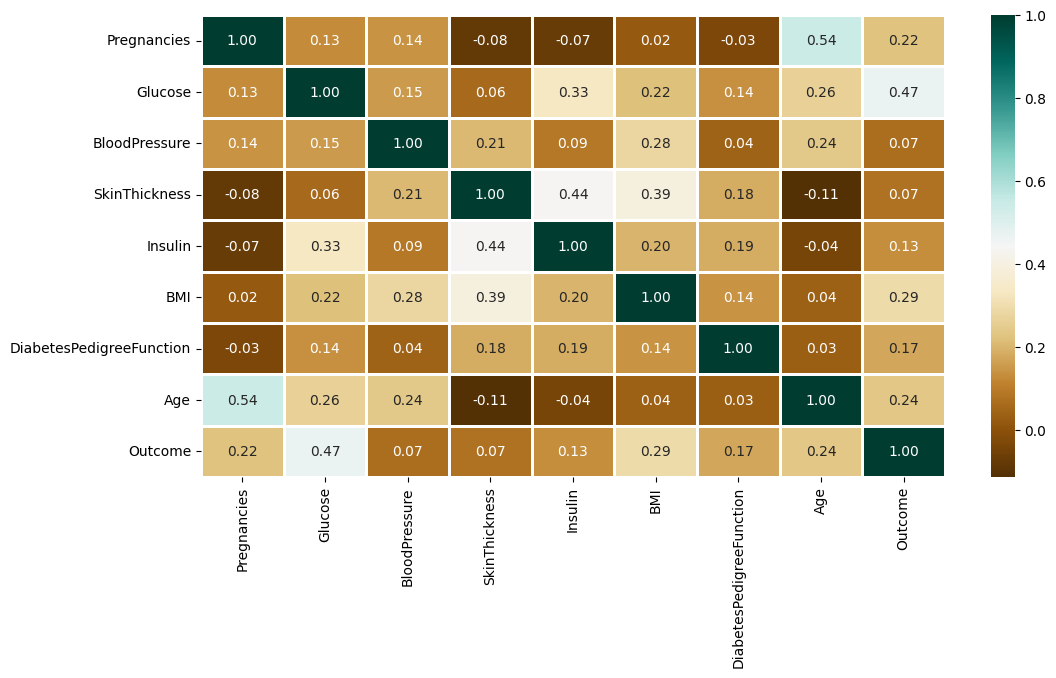

In [28]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

## 5. Data Preprocessing



In [37]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Split train/test:

Because Glusecose feature has strongly correlated with the label, we need to ensures each subgroup within the population receives proper representation within the train set and test set also!

<Axes: >

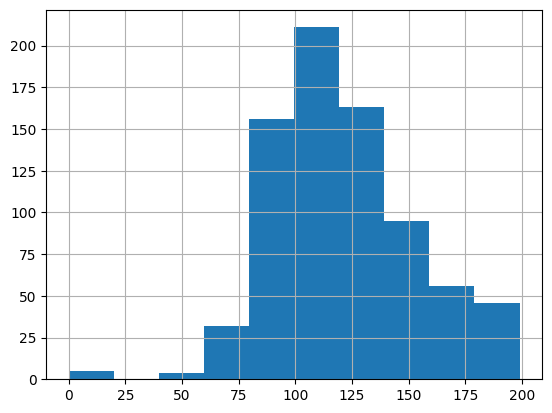

In [38]:
df["Glucose"].hist()

In [39]:
df["Glucose_cat"] = pd.cut(df["Glucose"],
                               bins=[-1,50.0, 75.0, 100.0,125.0,150.0,175.0,np.inf],
                               labels=[1, 2, 3,4,5,6,7])

<Axes: >

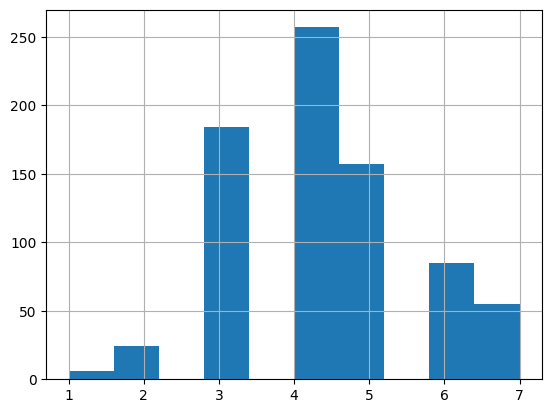

In [40]:
df["Glucose_cat"].hist()

In [41]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Glucose_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [42]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Glucose_cat", axis=1, inplace=True)

In [43]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 142 to 406
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.0 KB


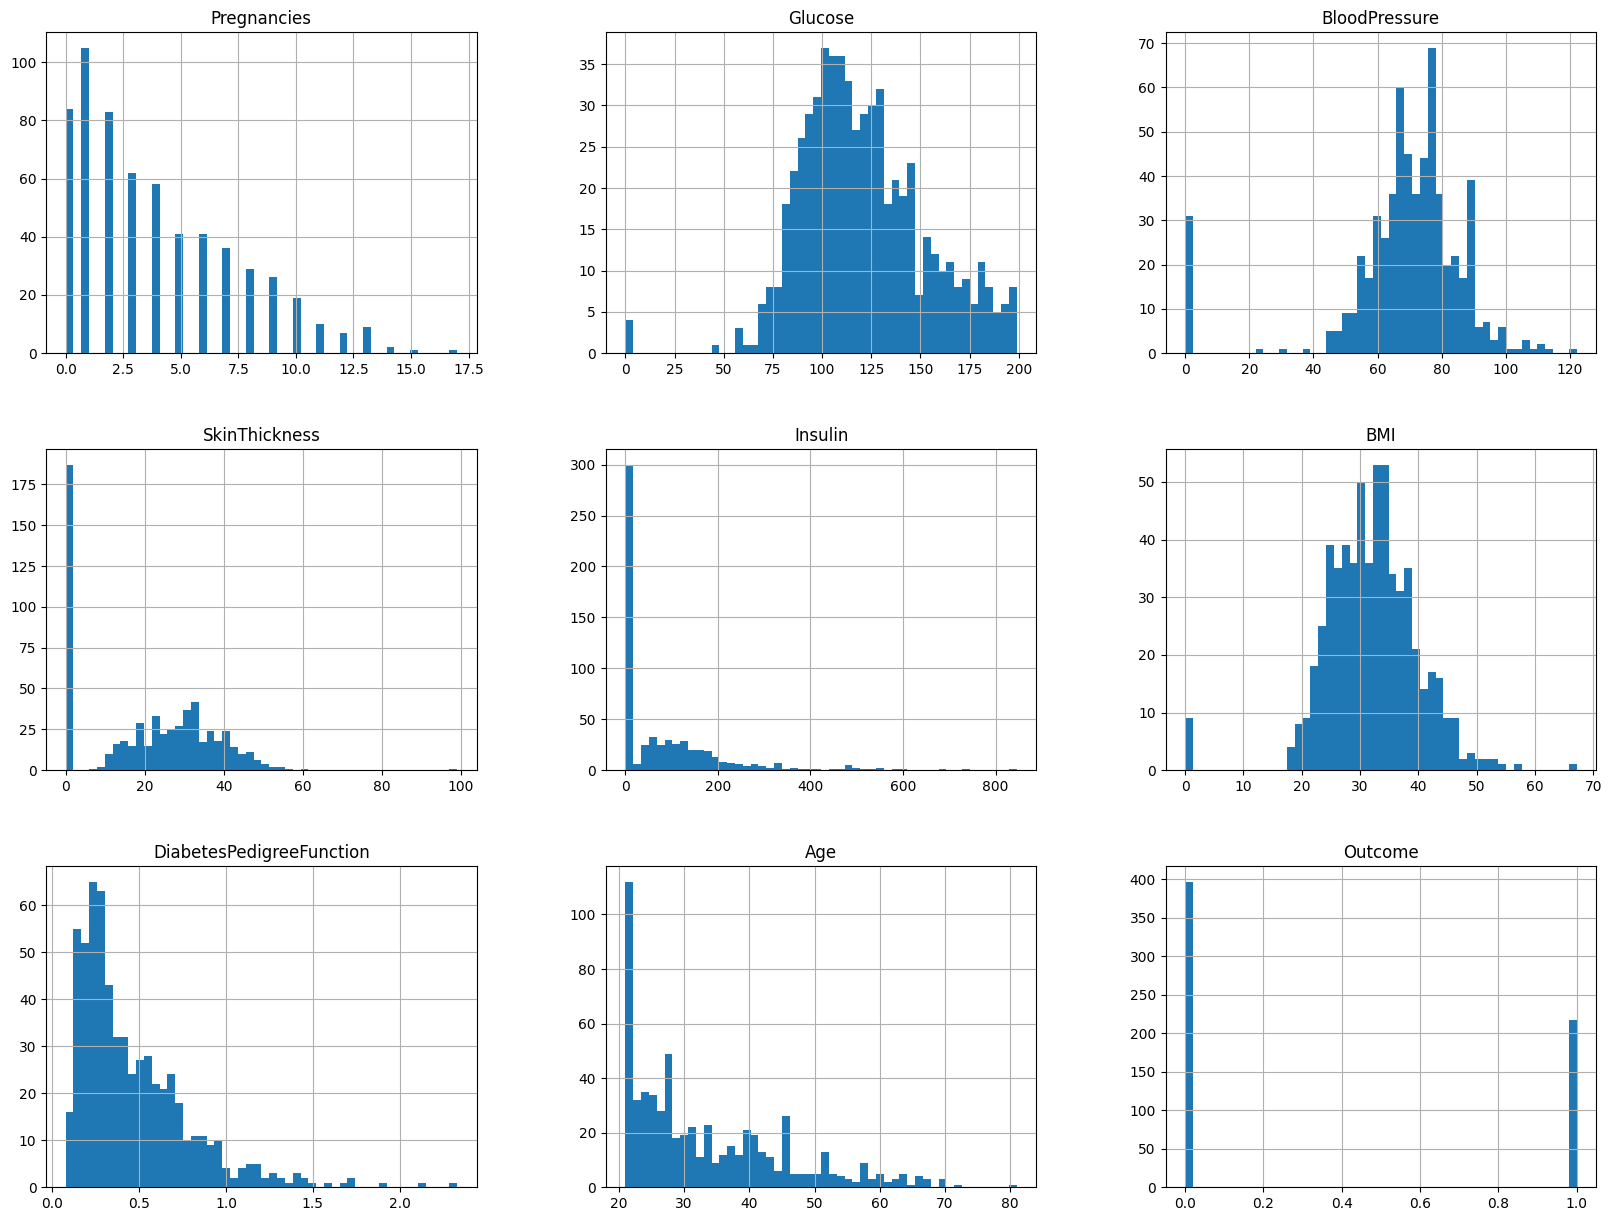

In [44]:
strat_train_set.hist(bins=50, figsize=(20, 15));

To prevent **data leakage**, put the test set away !!!


In [45]:
X_train=strat_train_set[[i  for i in strat_train_set.columns if i != 'Outcome']]
y_train=strat_train_set[['Outcome']]
X_test=strat_test_set[[i  for i in strat_test_set.columns if i != 'Outcome']]
y_test=strat_test_set[['Outcome']]

In [46]:
baseline_path= './data/baseline_data'
try:
    os.makedirs(baseline_path, exist_ok = True)
    print("Directory '%s' created successfully" %baseline_path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory './data/baseline_data' created successfully


In [48]:
train_x_path=f'{baseline_path}/train_x.parquet'
train_y_path=f'{baseline_path}/train_y.parquet'
test_x_path=f'{baseline_path}/test_x.parquet'
test_y_path=f'{baseline_path}/test_y.parquet'

In [49]:
X_train.to_parquet(train_x_path, index=False)
y_train.to_parquet(train_y_path, index=False)
X_test.to_parquet(test_x_path, index=False)
y_test.to_parquet(test_y_path, index=False)

In [50]:
# Capture the current state of dataset
! dvc add data

8120.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/hn/diabete_prediction/.dvc/cache/files/md5'| |0/? 
                                                                                
!
  0%|          |Adding data to cache                  0/4 [00:00<?,     ?file/s]
                                                                                
!
Checking out /home/hn/diabete_prediction/data         |0.00 [00:00,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 60.93file/s]

To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true
⠋ Checking graph
Adding...                                                                       
!
                                                                

In [51]:
! git add data.dvc
! git commit -m "Splited baseline data"

8130.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8135.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8135.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[main 8f9dd04] Splited baseline data
 1 file changed, 3 insertions(+), 3 deletions(-)


## 6. Model Experimentation and MLflow Tracking

1. Baseline models on raw data
2. Models with cleaned data
3. XGBoost with StandardScaler
4. XGBoost with MinMaxScaler
5. XGBoost with Log Transformation
6. XGBoost with Power Transformation


### Experiment 1: Base-line model (without data processing):

In [64]:
X_train = pd.read_parquet(train_x_path)
y_train= pd.read_parquet(train_y_path)
X_test= pd.read_parquet(test_x_path)
y_test= pd.read_parquet(test_y_path)

In [65]:
list(X_test.loc[0,:])

[0.0, 120.0, 74.0, 18.0, 63.0, 30.5, 0.285, 26.0]

In [66]:
def model_evaluation(model, X_test, y_test):
    metrics= {}

    pred = model.predict(X_test)
    acc = accuracy_score(y_test.values.ravel(), pred)
    metrics["test_accuracy"] = acc
    metrics["test_f1_score"]= f1_score(y_test.values.ravel(), pred)
    metrics["test_auc_score"]= roc_auc_score(y_test.values.ravel(), pred)

    return metrics

In [68]:
def model_log(experiment_name, run_name, model, X_test,metrics):
    mlflow.set_experiment(
    f"Diabetes_prediction_{experiment_name}")

    mlflow.set_tag("mlflow.runName", run_name)
    #mlflow log
    mlflow.log_params(model.get_params())
    mlflow.log_metrics(metrics)

    pred= model.predict(X_test)
    signature = infer_signature(X_test, pred)

    mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="model",
                signature=signature,
            )
    mlflow.end_run()

#### LogisticRegression model:

In [69]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-lr-model', lr, X_test,metrics)
metrics


/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp1-lr-model at: http://localhost:5000/#/experiments/935227455961715813/runs/854c359b7c864c26bb454885b2cfe09b
🧪 View experiment at: http://localhost:5000/#/experiments/935227455961715813


{'test_accuracy': 0.7272727272727273,
 'test_f1_score': 0.5227272727272727,
 'test_auc_score': 0.6575290310298878}

#### RandomForest model:

In [70]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-rfc-model', rfc, X_test,metrics)
metrics

/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp1-rfc-model at: http://localhost:5000/#/experiments/486323602626318469/runs/35e3301e80584c2ea1624d081d8c67f1
🧪 View experiment at: http://localhost:5000/#/experiments/486323602626318469


{'test_accuracy': 0.7207792207792207,
 'test_f1_score': 0.5567010309278351,
 'test_auc_score': 0.6724728726442032}

#### XGBOOST model:

In [71]:

EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-xgb-model', xgb_model, X_test,metrics)
metrics

/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp1-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/b25bf44be0c74b4ea39ba234af3551c0
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6060606060606061,
 'test_auc_score': 0.7067390062821246}

In [72]:
metrics

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6060606060606061,
 'test_auc_score': 0.7067390062821246}

### Deal with high zero values in some columns:

"we observed a high value of 0 in values such as Glucose, BloodPressure, SkinThickness, Insulin, and BMI in our dataset. These values cannot be 0!!! So we need replace them with other values."


In [73]:
X_train = pd.read_parquet(train_x_path)
y_train= pd.read_parquet(train_y_path)
X_test= pd.read_parquet(test_x_path)
y_test= pd.read_parquet(test_y_path)

In [74]:
highzero_columns = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
X_train[highzero_columns] = X_train[highzero_columns].replace(0,np.NaN)

In [75]:
#Finding the mean of the column having NaN
Glucose_mean_value=X_train['Glucose'].mean()
BloodPressure_mean_value=X_train['BloodPressure'].mean()
SkinThickness_mean_value=X_train['SkinThickness'].mean()
Insulin_mean_value=X_train['Insulin'].mean()
BMI_mean_value=X_train['BMI'].mean()


# Let's fill in the missing values with the mean of each column.
X_train['Glucose'].fillna(value=Glucose_mean_value, inplace=True)
X_train['BloodPressure'].fillna(value=BloodPressure_mean_value, inplace=True)
X_train['SkinThickness'].fillna(value=SkinThickness_mean_value, inplace=True)
X_train['Insulin'].fillna(value=Insulin_mean_value, inplace=True)
X_train['BMI'].fillna(value=BMI_mean_value, inplace=True)

/tmp/ipykernel_68810/3653587539.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Glucose'].fillna(value=Glucose_mean_value, inplace=True)
/tmp/ipykernel_68810/3653587539.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [76]:
X_train.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

source: https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/

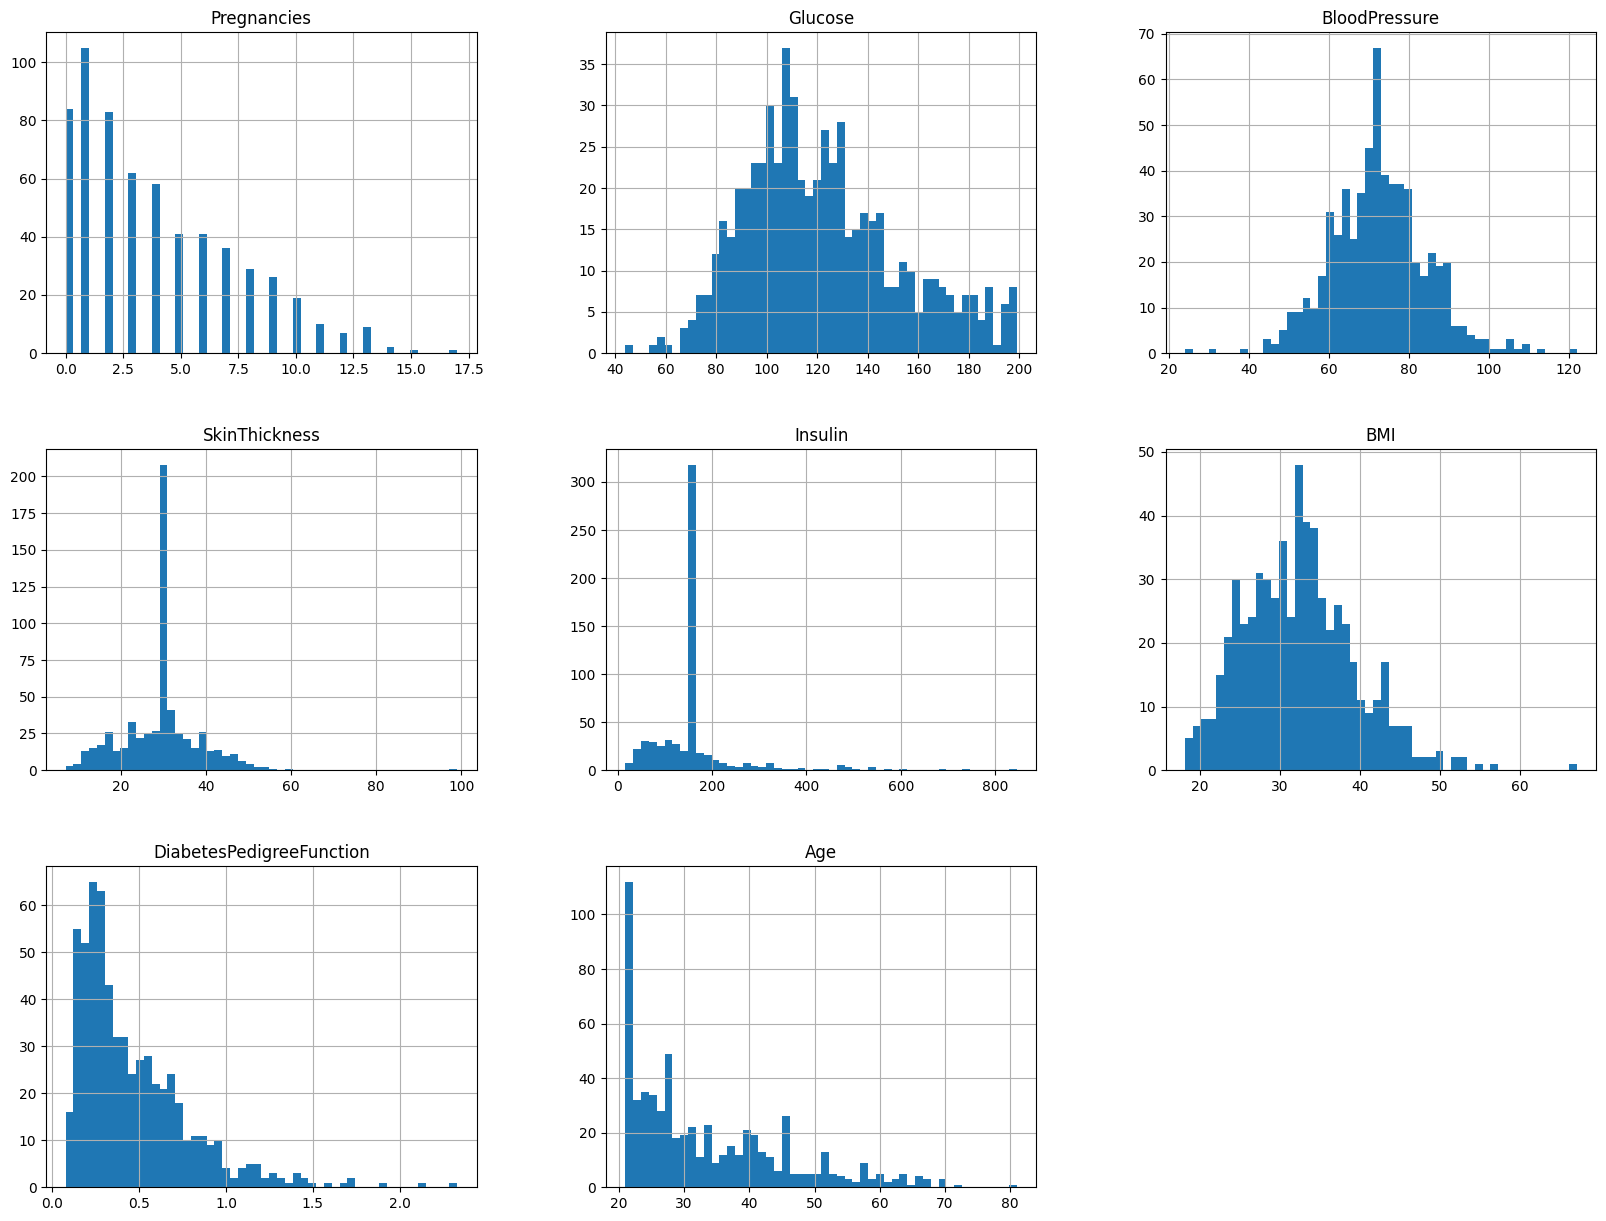

In [77]:
X_train.hist(bins=50, figsize=(20, 15));

### Remove outlier:

"And the presence of outliers in Insulin, BMI, BloodPressure, Pregnancies, DiabetesPedigreeFunction and Age, which may cause problems during model fitting (esp. linear models) and may also result in inflated error metrics which give higher weights to large errors."

In [78]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

Let's check if there are outliers according to the threshold values

In [79]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [80]:
for col in X_train.columns:
    print(col, check_outlier(X_train, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [81]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [82]:
for col in X_train.columns:
    replace_with_thresholds(X_train, col)

/tmp/ipykernel_68810/130684917.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-35.025000000000034' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [83]:
for col in X_train.columns:
    print(col, check_outlier(X_train, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


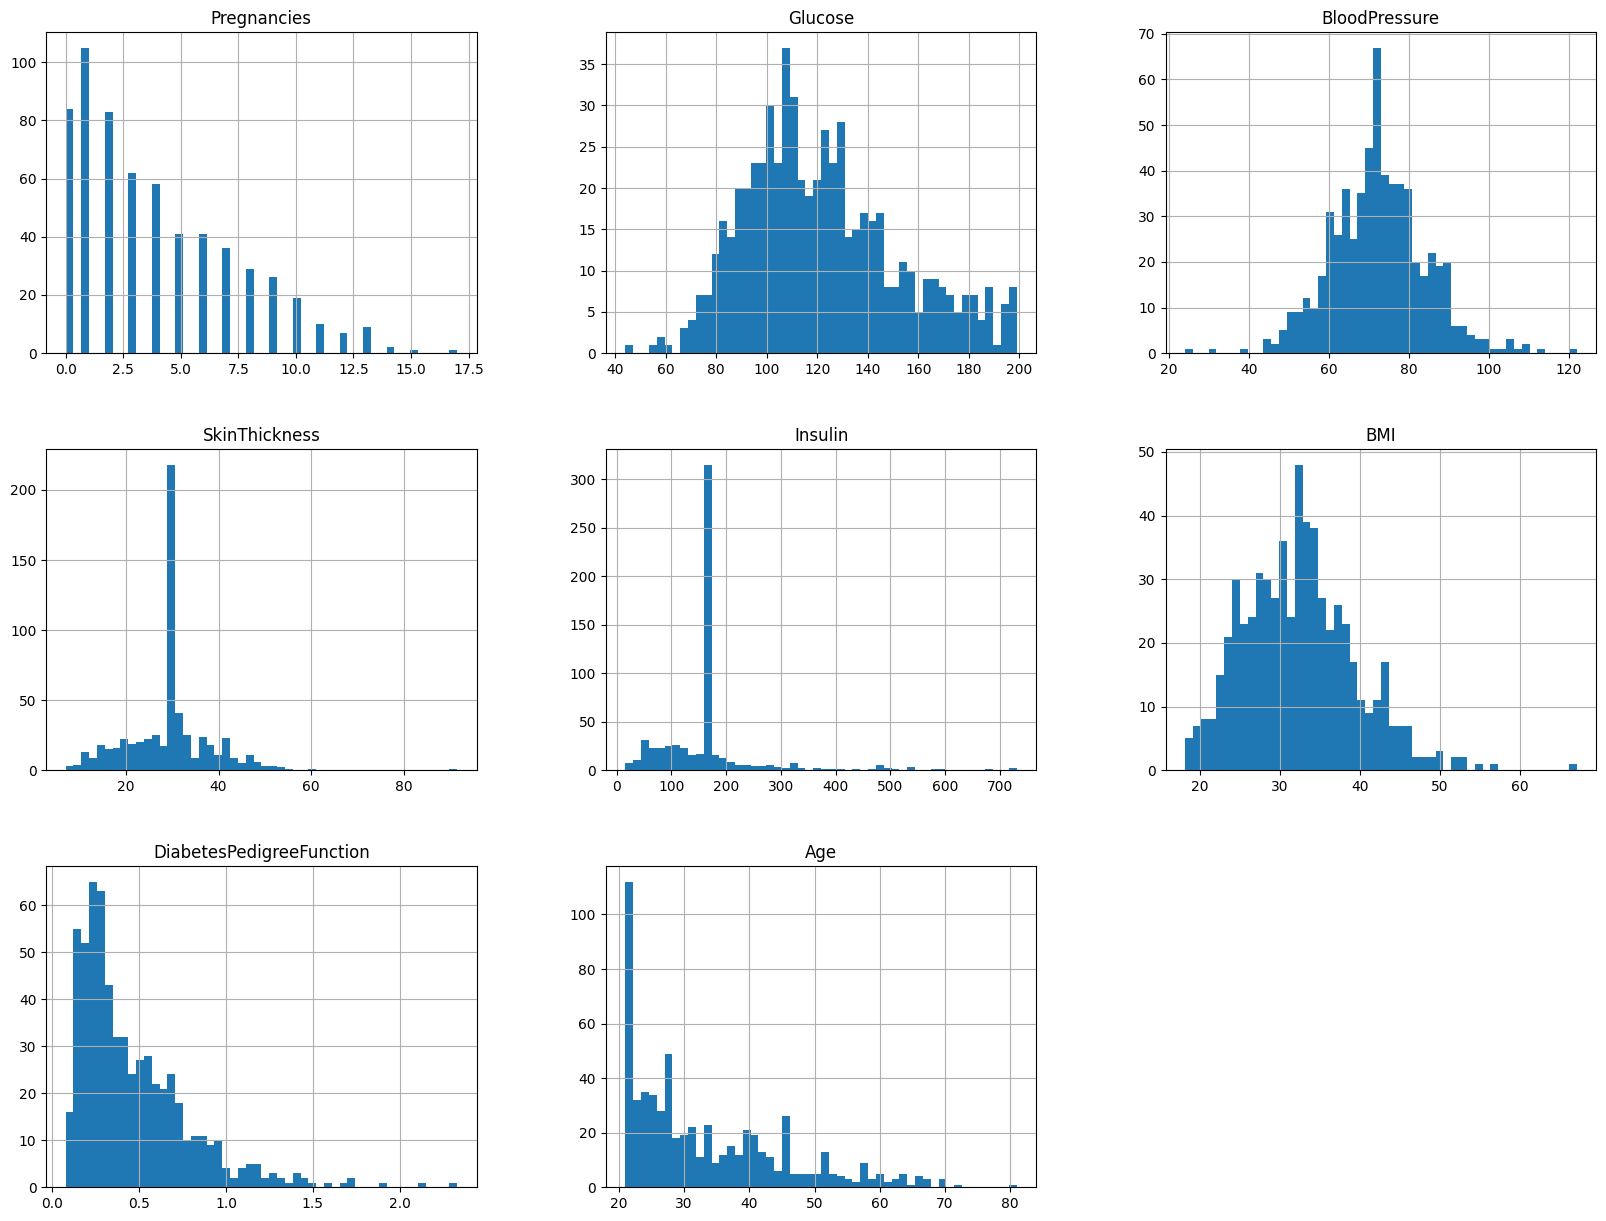

In [84]:
X_train.hist(bins=50, figsize=(20, 15));

### Experiment 2: Model with cleaned data (remove outlier + replace zero value):

In [94]:
cleaned_path='./data/cleaned_data'

In [91]:
cleaned_train_x_path=f'{cleaned_path}/cleaned_train_x.parquet'
cleaned_train_y_path=f'{cleaned_path}/cleaned_train_y.parquet'
cleaned_test_x_path=f'{cleaned_path}/cleaned_test_x.parquet'
cleaned_test_y_path=f'{cleaned_path}/cleaned_test_y.parquet'

In [92]:
X_train.to_parquet(cleaned_train_x_path, index=False)
y_train.to_parquet(cleaned_train_y_path, index=False)

In [95]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train = pd.read_parquet(cleaned_train_y_path)
X_test = pd.read_parquet(cleaned_test_x_path)
y_test = pd.read_parquet(cleaned_test_y_path)

#### LogisticRegression model:

In [89]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-lr-model', lr, X_test,metrics)
metrics

/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp2-lr-model at: http://localhost:5000/#/experiments/935227455961715813/runs/32df19c95c6b4bf98486932334b066b1
🧪 View experiment at: http://localhost:5000/#/experiments/935227455961715813


{'test_accuracy': 0.7142857142857143,
 'test_f1_score': 0.5111111111111111,
 'test_auc_score': 0.64782029316581}

#### RandomForest model:

In [96]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-rfc-model', rfc, X_test,metrics)
metrics

/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp2-rfc-model at: http://localhost:5000/#/experiments/486323602626318469/runs/079c08e431484e16a80c775eba8a8243
🧪 View experiment at: http://localhost:5000/#/experiments/486323602626318469


{'test_accuracy': 0.7142857142857143,
 'test_f1_score': 0.5599999999999999,
 'test_auc_score': 0.6725680563487532}

#### XGBoost model:

In [97]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-xgb-model', xgb_model, X_test,metrics)
metrics

/home/hn/diabete_prediction/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run exp2-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/432d779bfb5e462b95b293beb28a6bf4
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

In [98]:
metrics

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 3: (cleaned_data + XGBoost model + standard scaler):

In [99]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [100]:
list(X_test.loc[1,:])

[10.0, 90.0, 85.0, 32.0, 159.21587301587303, 34.9, 0.825, 56.0]

In [101]:
y_test

,Outcome
0,0
1,1
2,1
3,0
4,0
...,...
149,0
150,0
151,0
152,1


In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [105]:
import joblib
import os

models_dir = "/home/hn/diabete_prediction/models"
scaler_path = os.path.join(models_dir, "scaler.gz")

joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

official_scaler = joblib.load(scaler_path)
print("Scaler loaded successfully")

Scaler saved to /home/hn/diabete_prediction/models/scaler.gz
Scaler loaded successfully


In [106]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp3-xgb-model', xgb_model, X_test,metrics)
metrics

🏃 View run exp3-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/aebe0332de544ab08715a5f227b7595e
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

In [107]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp3-xgb-model-official-final', xgb_model, X_test,metrics)
metrics

🏃 View run exp3-xgb-model-official-final at: http://localhost:5000/#/experiments/147340113308834119/runs/7bd4570032d84d11a12bf0851b4ab0dd
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 4: (cleaned_data + XGBoost model + minmaxScaler ):

### Experiment 5: (cleaned_data + XGBoost model + LogTransformation + standardScaler  ):

In [129]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

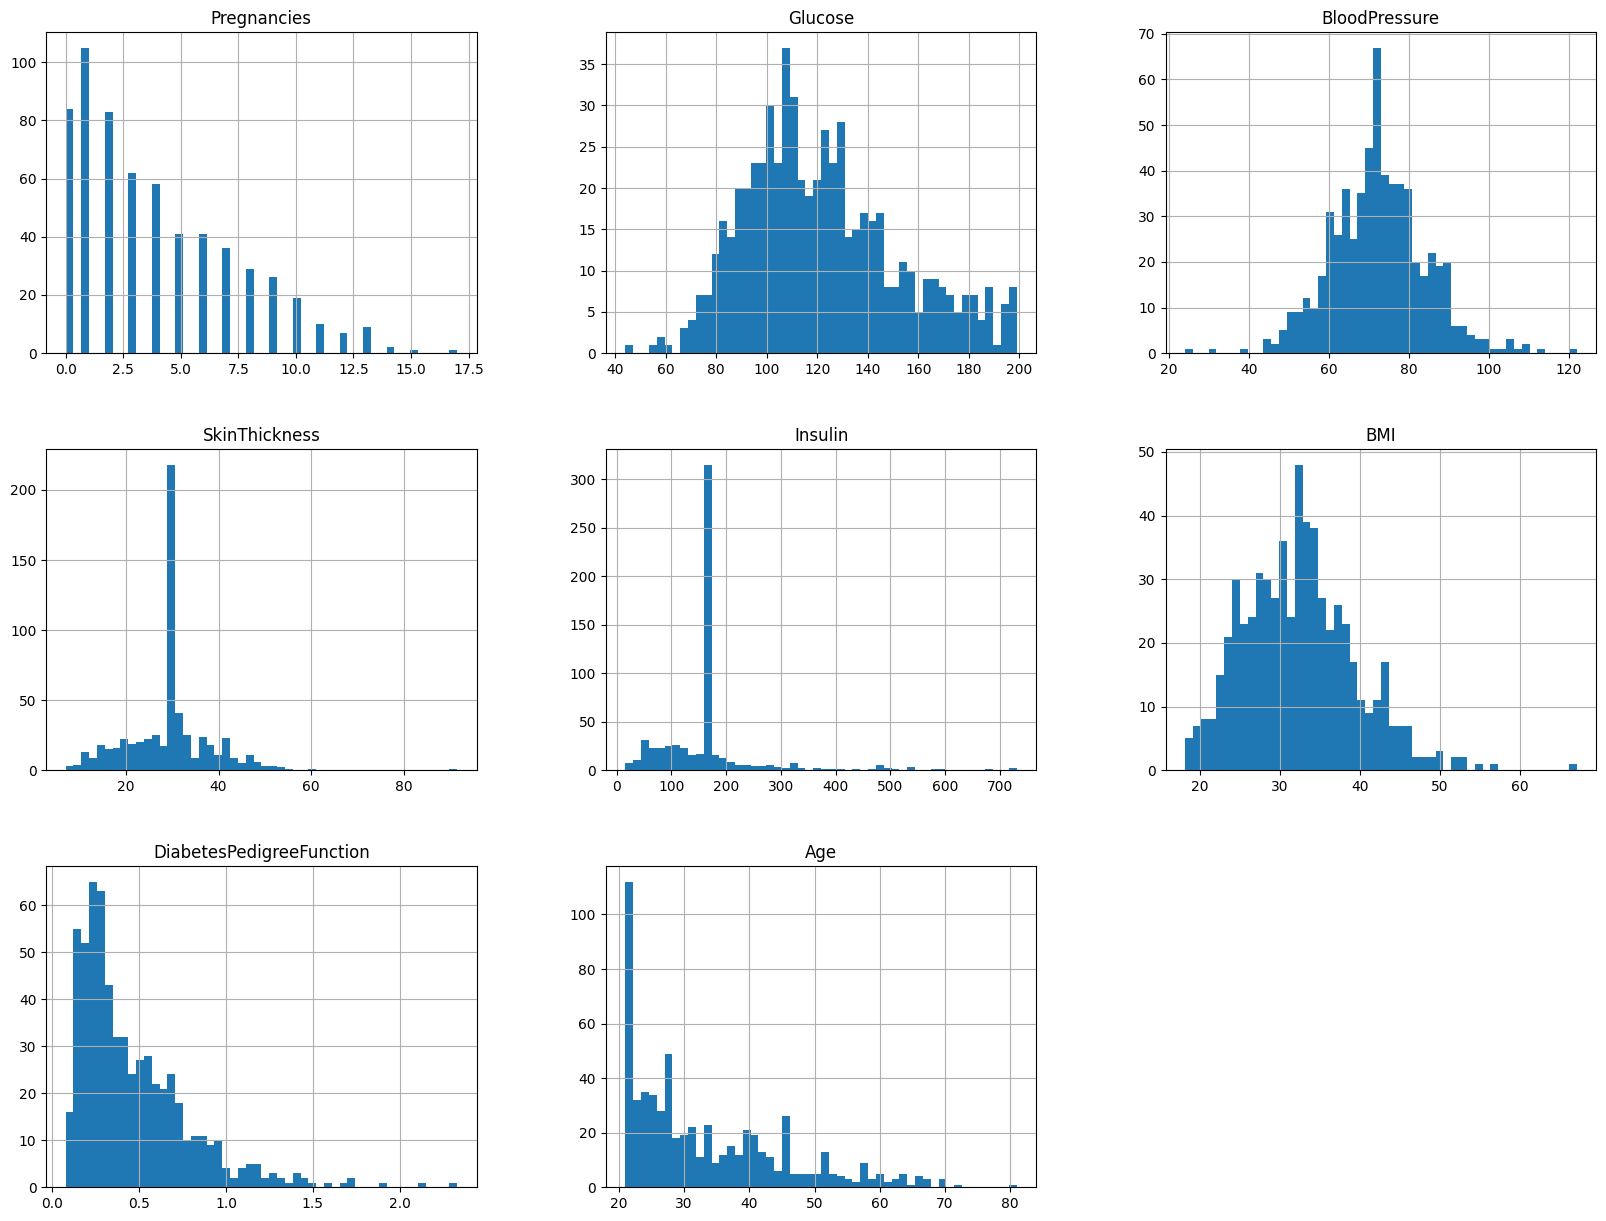

In [130]:
X_train.hist(bins=50, figsize=(20, 15));

In [131]:
X_train= X_train[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))
X_test= X_test[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))

In [132]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [133]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp5-xgb-model', xgb_model, X_test,metrics)
metrics

🏃 View run exp5-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/c20ac9c79e484a379f5503b11c192399
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7077922077922078,
 'test_f1_score': 0.4943820224719101,
 'test_auc_score': 0.6380163715971826}

In [ ]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-rfc-model', rfc, X_test,metrics)
metrics

{'test_accuracy': 0.6363636363636364,
 'test_f1_score': 0.4042553191489362,
 'test_auc_score': 0.5697696554349895}

In [134]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-lr-model', lr, X_test,metrics)
metrics

🏃 View run exp4-lr-model at: http://localhost:5000/#/experiments/935227455961715813/runs/f5aae1c6178b45aa9fae279634bc91b1
🧪 View experiment at: http://localhost:5000/#/experiments/935227455961715813


{'test_accuracy': 0.7012987012987013,
 'test_f1_score': 0.37837837837837845,
 'test_auc_score': 0.5935655815724348}

In [135]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [136]:
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [137]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-xgb-model', xgb_model, X_test,metrics)
metrics

🏃 View run exp4-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/43f147a75dbf4a4a90f159365a7328e9
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 6: (cleaned_data + XGBoost model + PowerTransformation + standardScaler  ):

In [118]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [119]:
right_skewed_cols=['DiabetesPedigreeFunction', 'Age']

In [120]:
from sklearn.preprocessing import PowerTransformer
transPowerYeojohnson=PowerTransformer(method="yeo-johnson")

X_train[right_skewed_cols]=transPowerYeojohnson.fit_transform(X_train[right_skewed_cols])
X_test[right_skewed_cols]=transPowerYeojohnson.transform(X_test[right_skewed_cols])

In [121]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [122]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp6-xgb-model', xgb_model, X_test,metrics)
metrics

🏃 View run exp6-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/d4d42705d99f4229bacb0075546f3fea
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

In [ ]:
xgb_model.predict([X_test[0]])[0]

0

In [124]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

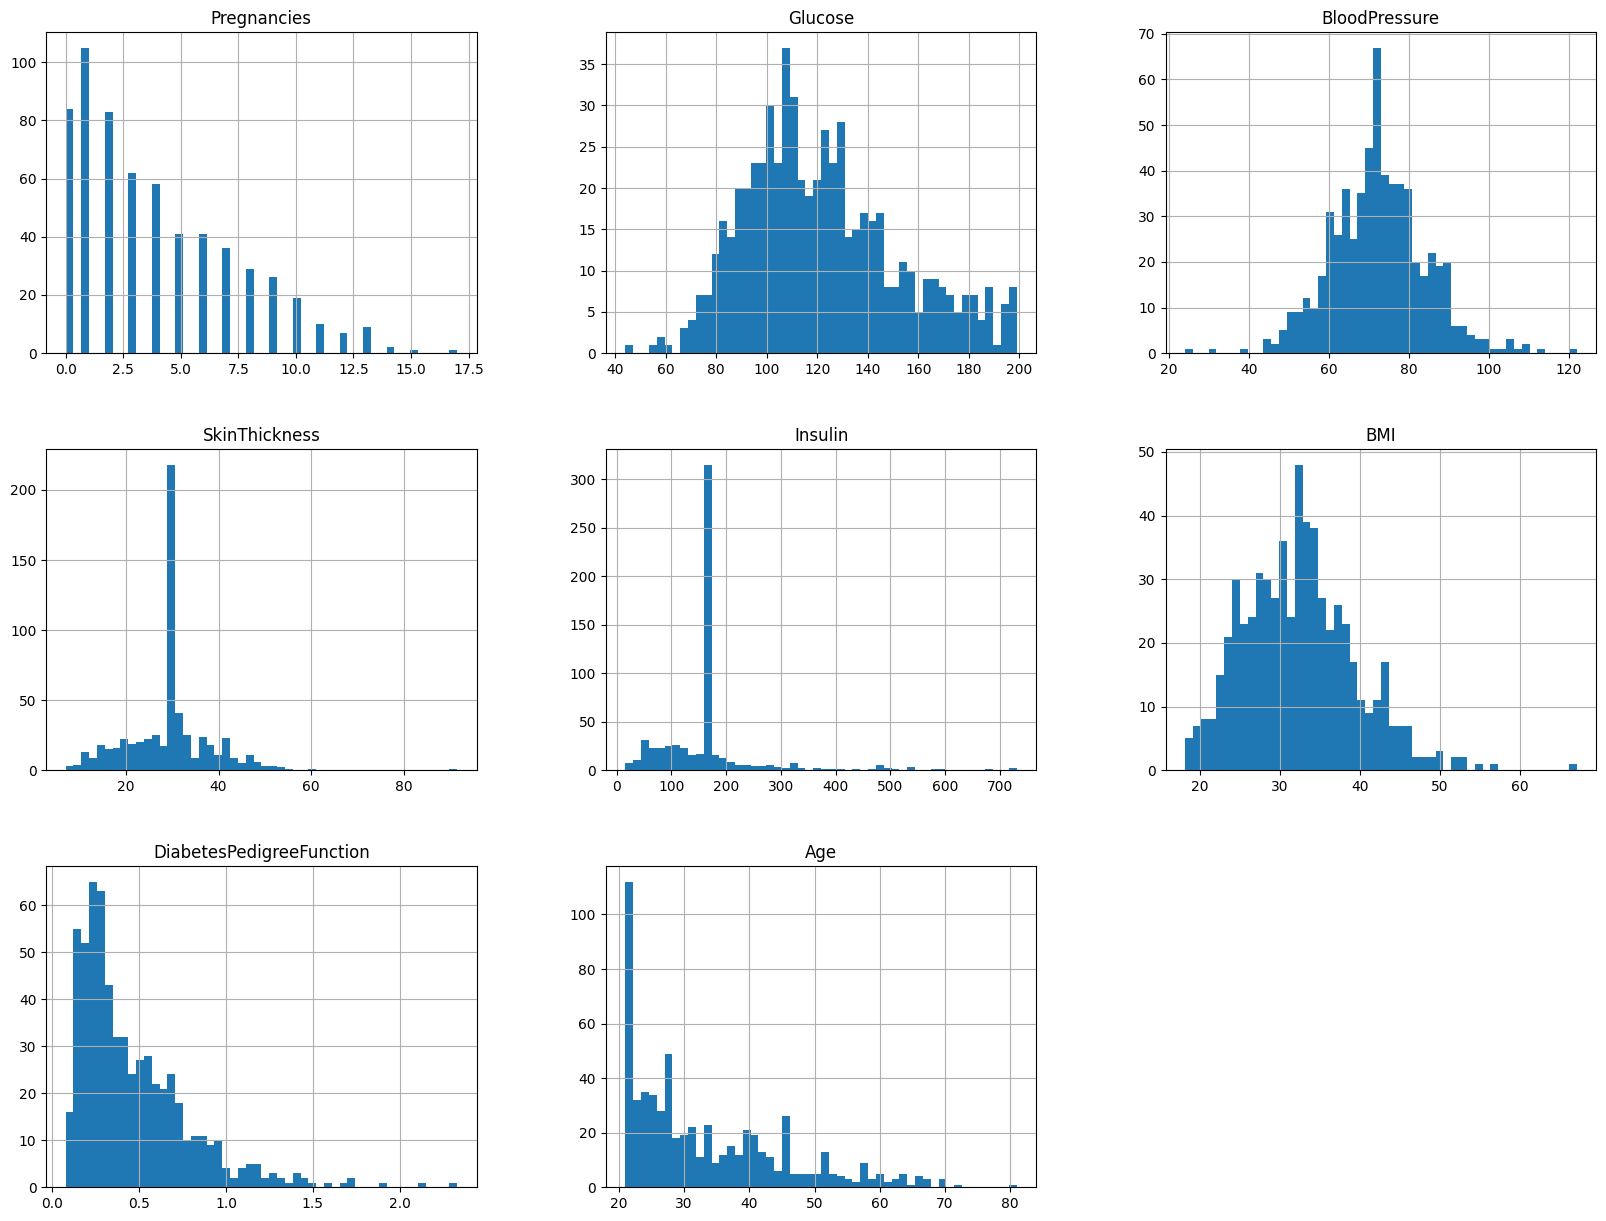

In [125]:
X_train.hist(bins=50, figsize=(20, 15));

In [126]:
X_train= X_train[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))
X_test= X_test[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))

In [114]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [115]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp5-xgb-model', xgb_model, X_test,metrics)
metrics

🏃 View run exp5-xgb-model at: http://localhost:5000/#/experiments/147340113308834119/runs/b8129b6118134cba93a8f0f24b7562ba
🧪 View experiment at: http://localhost:5000/#/experiments/147340113308834119


{'test_accuracy': 0.7077922077922078,
 'test_f1_score': 0.4943820224719101,
 'test_auc_score': 0.6380163715971826}

In [127]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-rfc-model', rfc, X_test,metrics)
metrics

🏃 View run exp4-rfc-model at: http://localhost:5000/#/experiments/486323602626318469/runs/15d313054e22451bbff76efd9aceceef
🧪 View experiment at: http://localhost:5000/#/experiments/486323602626318469


{'test_accuracy': 0.6363636363636364,
 'test_f1_score': 0.4042553191489362,
 'test_auc_score': 0.5697696554349895}

In [128]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-lr-model', lr, X_test,metrics)
metrics

🏃 View run exp4-lr-model at: http://localhost:5000/#/experiments/935227455961715813/runs/721eb4c1a4e74f0fb8c05d75030fb65e
🧪 View experiment at: http://localhost:5000/#/experiments/935227455961715813


{'test_accuracy': 0.7012987012987013,
 'test_f1_score': 0.37837837837837845,
 'test_auc_score': 0.5935655815724348}

In [142]:
import joblib
import os

model_path = os.environ.get("MODEL_PATH", "./models/model.pkl")
scaler_path = os.environ.get("SCALER_PATH", "./models/scaler.gz")

model = joblib.load(model_path)
scaler = joblib.load(scaler_path)